<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/JonasNylund/Lab-5/jonasnylund_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Quadrature**
**Jonas Nylund**

# **Abstract**

In this lab report we implement a few different methods for numeric integration and verify their accuracy. All implementations gives the desired output.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [2]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Jonas Nylund (jonasnyl@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
from scipy import optimize;
import matplotlib.pyplot as plt;


# **Introduction**

We include here our own implementation of Newtons method for systems, as numpys built in one did not converge for some reason. 


In [0]:
def grad(f, x, delta=10**(-6)):
  d = np.zeros(len(x));
  for i in range(len(x)):
    dx = np.zeros(len(x));
    dx[i] += delta/2;
    d[i] = (f(x+dx)-f(x-dx))/delta;

  return d;

def jacobi(f, x, delta=10**(-6)):
  n = len(x);
  J = np.zeros((n,n));
  for i in range(n):
    J[i,:] = grad(f[i], x, delta=delta);

  return J;

def newtonVector(f, x0=0, tolerance=10**(-10), max_iter=100):
  if(x0 is 0):
    x = np.zeros(len(f)-1);
  else:
    assert len(f)-1 == len(x0);
    x = x0;

  i=0;
  while (np.linalg.norm(f[0](x)) > tolerance):
    J = jacobi(f[1:],x);  ## f[0] is vector function, f[1:] is f1,f2...
    dx = np.linalg.solve(J, f[0](x));
    x -= dx;

    i+=1;
    if(i> max_iter):
      raise ArithmeticError("Function does not converge");

  return x;

# **Methods**

**Gauss Quadrature**

The quad points and weights are calculated from $$ \int_a^b p(x)dx = w_0p(x_0)+w_1p(x_1) $$ for a general cubic polynomial $p(x) = c_0 + c_1x + c_2x^2 + c_3x^3$. This gives us a system of equations;
\begin{align}
c_0(b-a) =~& c_0(w_0+w_1) \\
\frac12 c_1(b^2-a^2) =~ & c_1(w_0x_0 + w_1x_1)\\
\frac23 c_2(b^3-a^3) =~ & c_2(w_0x_0^2+w_1x_1^2)\\
\frac34 c_3(b^4-a^4) =~ & c_3(w_0w_0^3+w_1x_1^3)\\
\end{align}

Which we for instance can solve using Newtons method for systems of equations.
For the case of $a=0, b=1$, we get $x_0\approx 0.211, x_1 \approx 0.778, w_0=w_1=0.5$.

The integral can then be approximated as follows.

In [0]:
def getQuadPoints(a,b):
  fns = [
      lambda x: x[0]+x[1]-(b-a),
      lambda x: x[0]*x[2] + x[1]*x[3] - 1/2*(b**2-a**2),
      lambda x: x[0]*x[2]**2 + x[1]*x[3]**2 -1/3*(b**3-a**3),
      lambda x: x[0]*x[2]**3 + x[1]*x[3]**3 -1/4*(b**4-a**4)
  ];
  f = lambda x: [fns[i](x) for i in range(4)];

  x0 = [1,1,a,b];
  return newtonVector([f]+fns, x0=x0);

def gaussQuad(f,a=0,b=1):
  if(a == 0 and b == 1):
    qp = [0.5, 0.5, 0.21132487, 0.78867513];
  else:
    qp = getQuadPoints(a,b);

  return qp[0]*f(qp[2]) + qp[1]*f(qp[3]);

In [68]:
def oneDimCubePolynomial():
  c = [np.random.rand()*2-1 for i in range(4)];
  C = [0] + [c[i]/(i+1) for i in range(len(c))];

  p = np.polynomial.polynomial.Polynomial(c);
  P = np.polynomial.polynomial.Polynomial(C);

  return p,P;

p,P = oneDimCubePolynomial();

print(getQuadPoints(0,1));
print("Diff quad(p,0,1) - int_0^1(p(x)dx:", gaussQuad(p)-(P(1)-P(0)));

[0.5        0.5        0.21132487 0.78867513]
Diff quad(p,0,1) - int_0^1(p(x)dx: -4.172083567510754e-09


**3-point edge midpoint on the unit triangle**

In the three point edge midpoint quadrature, the quad points are, per definition, the points on the middle of the edges of the unit triangle $(0,1/2), (1/2,0), (1/2,1/2)$.

The exact solution is given by the integral 
$$
\int_{x=0}^1\int_{y=0}^{x-1} p(x,y)dydx
$$ which for a general quadratic polyomial in $p(x,y) = c_0x^2+c_1y^2+c_2xy+c_3x+c_4y+c_5$ gives
$$
\int_{x=0}^1\int_{y=0}^{x-1} c_0x^2+c_1y^2+c_2xy+c_3x+c_4y+c_5 dydx 
$$
$$
= \int_0^1 \left[c_0x^2(x-1) + \frac{c_1}3(1-x)^3 + \frac{c_2}2x(1-x)^2+c_3x(1-x)+\frac{c_4}2(1-x)^2+c_5(1-x)\right]dx
$$
which is a cubic polynomial in one variable, that we can solve exactly with a gauss quadrature from problem 1.

In [0]:
def threePointMidpointQuad(f):
  return (f(0.5,0) + f(0,0.5) + f(0.5, 0.5))/6;

In [69]:
def twoDimQuadPolynomial():
  c = [np.random.rand()*2-1 for i in range(6)];
  f1 = lambda x,y: c[0]*x**2 + c[1]*y**2 + c[2]*x*y + c[3]*x + c[4]*y + c[5];
  f2 = lambda x: c[0]*(1-x)*x**2 + c[1]/3*(1-x)**3 + c[2]/2*(1-x)**2*x + c[3]*x*(1-x)+c[4]/2*(1-x)**2+c[5]*(1-x);
  return f1,f2;

f1,f2 = twoDimQuadPolynomial();
print(np.abs(threePointMidpointQuad(f1)-gaussQuad(f2)));

9.592368011013264e-10


**Monte Carlo quadrature**

Sample points randomly on the unit interval, and compute the arithmetic average of the function over the interval. The integral is then computed as the interval length times the average.
The one and two dimensional variants of the Monte Carlo integration is combined into a single function, that should also work for an number of dimensions.

The volume of a n-D simplex is $\frac1{n!}$ [(P. Stein, A Note on the Volume of a Simplex)](https://www.jstor.org/stable/2315353?origin=crossref&seq=1#metadata_info_tab_contents), and so the average value of the function is multiplied by $1/n!$ to get the integral in the unit simplex.

Uniformly samling points in the volume is done by first calculating a random point on the limiting surface, given by $\sum_{i=1}^n x_i=1$, and then picking a random point on a ray from origo to the point on the surface. The point on the surface can be uniformly picked by splitting the interval [0 1] into n sections, and calculating the length of each interval. This gives a random point on the surface. 
Since we want to pick the points unifomrly in the volume, we bias the distance from origo by a power of 1/n, since the volume of a n-simplex grows as $r^n$ with distance $r$ from origo. This ensures that we get a uniform distribution.

In [0]:
def point(dim):
  x = np.random.rand(dim-1);
  x = np.concatenate((x,[0,1]));
  x = np.diff(np.sort(x));
  return x*np.power(np.random.rand(), 1/dim);

def monteCarloQuad(f, dim, n):
  avg = 0;
  for i in range(n):
    x = point(dim);
    v = f(*x);
    avg += v;

  return avg/(n * np.math.factorial(dim));

# **Results**

In [66]:
def test_gauss():
  p,P = oneDimCubePolynomial();
  return  gaussQuad(p)-(P(1)-P(0)) < 10**(-6);

def test_mp():
  f1,f2 = twoDimQuadPolynomial();
  return np.abs(threePointMidpointQuad(f1)-gaussQuad(f2)) < 10**(-6);

n_tests = 1000;
print("Testing Gauss quad...");
for i in range(n_tests):
  assert test_gauss();
print(str(n_tests) + " tests passed");
print("Testing three point midpoint quad...");
for i in range(n_tests):
  assert test_mp();
print(str(n_tests) + " tests passed");

Testing Gauss quad...
1000 tests passed
Testing three point midpoint quad...
1000 tests passed


**Distribution of random points**
It is important that the points that we pick are uniformly distributed for monte carlo integration.
We plot the one d-case with two coordinates to make it easier to see the distribution.

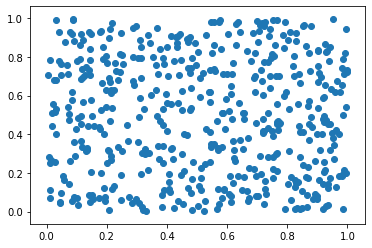

In [61]:
x = [];
y = [];
for i in range(500):
  x.append(point(1));
  y.append(point(1));
plt.scatter(x,y);

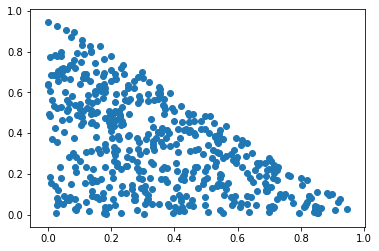

In [62]:
x = [];
y = [];
for i in range(500):
  p = point(2);
  x.append(p[0]);
  y.append(p[1]);
plt.scatter(x,y);

Test Monte carlo in 1D. Exact integral used as reference value.

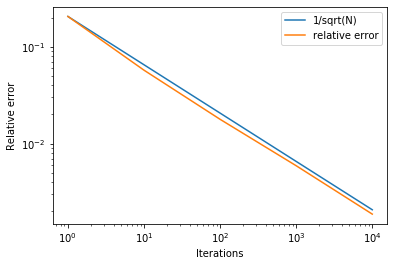

In [59]:
f,F = oneDimCubePolynomial();

err = [];
N = [];
n = 10;

for i in range(5):
  N.append(n**i);
  error = 0;
  for j in range(100):
    error += np.abs(monteCarloQuad(f, 1, n**i)-F(1))/np.abs(F(1));
  err.append(error/100);
  
plt.figure();
plt.xlabel("Iterations");
plt.ylabel("Relative error");
plt.loglog(N, 1/np.sqrt(N)*err[0]*np.sqrt(N[0]), label="1/sqrt(N)");
plt.loglog(N, err, label="relative error");
plt.legend();

Monte Carlo in 2D. Three point midpoint integral value used as reference value. 

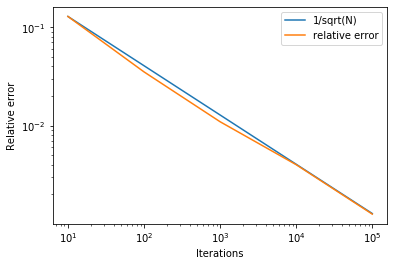

In [60]:
f,_ = twoDimQuadPolynomial();
ref = threePointMidpointQuad(f);

n = 10;
N = [];
error = [];
for i in range(1,6):
  err = 0;
  for j in range(50):
    err += np.abs((monteCarloQuad(f, 2, n**i)-ref)/ref);
  error.append(err/100);
  N.append(n**i);

plt.figure();
plt.loglog(N, 1/np.sqrt(N)*error[0]*np.sqrt(N[0]), label="1/sqrt(N)");
plt.loglog(N, error, label="relative error");
plt.xlabel("Iterations");
plt.ylabel("Relative error");
plt.legend();

# **Discussion**

All the implementations workes as prescribed, and Monte Carlo integration implemented for any unit simplex. The convergence rate follows a $\frac{1}{\sqrt n}$ dependence.  